In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import sys
import argparse
import h5py
from scipy.stats import t as student_t
from statsmodels.stats import multitest as mt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# IDP_df = pd.read_pickle('male_IDP_prototype.pkl')
# vars_df = pd.read_pickle('male_vars_prototype.pkl')

IDP_df = pd.read_pickle('female_subject_direction_ICA_deltas_IDP_STEVEnorm_deconf.pkl')
vars_df = pd.read_pickle('female_subject_direction_ICA_deltas_nIDP_STEVEnorm_deconf.pkl')

# IDP_names = np.loadtxt("IDP_names.txt", dtype=str, delimiter='\n')
with open('IDP_names.txt') as f:
    IDP_names = f.readlines()
    IDP_names = [l.strip('\n\r') for l in IDP_names]
    IDP_names = np.array(IDP_names)
# IDP_categories = np.loadtxt("IDP_categories.txt", dtype=str, delimiter='\n')
with open('IDP_categories.txt') as f:
    IDP_categories = f.readlines()
    IDP_categories = [l.strip('\n\r') for l in IDP_categories]
    IDP_categories = np.array(IDP_categories)
with open('varsHeader.txt') as f:
    varsHeader = f.readlines()
    varsHeader = [l.strip('\n\r') for l in varsHeader]
    varsHeader = np.array(varsHeader)
# vars_categories = np.loadtxt("vars_categories.txt", dtype=str, delimiter='\n')
with open('vars_categories.txt') as f:
    vars_categories = f.readlines()
    vars_categories = [l.strip('\n\r') for l in vars_categories]
    vars_categories = np.array(vars_categories)

In [3]:
vars_df.head()

,modality,bonf,fdr,dataframe
0,IC = 0,5.509794,3.524662,idx ...
1,IC = 1,5.509794,3.201534,idx ...


In [4]:
vars_df.iloc[0].dataframe.head()

,idx,names,Categories,pearson_r,t_test_statistic,p_values_corrected,p_values,abs_pearson_r,log_p_values,log_p_values_corrected
0,0,Ethnic background (0.0),Ethnic Background,0.027647,1.957215,0.627484,0.050378,0.027647,1.297762,0.202398
1,1,Ethnic background (1.0),Ethnic Background,0.035055,1.014186,0.919212,0.310787,0.035055,0.507537,0.036584
2,2,Ethnic background (2.0),Ethnic Background,0.039270,1.482522,0.793821,0.138423,0.039270,0.858792,0.100277
3,3,Genotype measurement batch (0.0),Genetic Markers,0.049738,3.478130,0.073135,0.000509,0.049738,3.292996,1.135872
4,4,Heterozygosity (0.0),Genetic Markers,0.009976,0.696801,0.984174,0.485960,0.009976,0.313399,0.006928


In [5]:
vars_over_bThr_list = []

for idx in range(len(vars_df)):
    df = vars_df.iloc[idx].dataframe
    bThr = vars_df.iloc[idx].bonf
    vars_over_bThr = df[df.log_p_values>=bThr].sort_values('log_p_values', ascending=False).names.to_list()
    for var in vars_over_bThr:
        vars_over_bThr_list.append(var)

In [6]:
print("Number of unique vars across all modalities: ", len(set(vars_over_bThr_list)))

Number of unique vars across all modalities:  169


In [7]:
unique_vars_over_bTHr = list(set(vars_over_bThr_list))

In [8]:
unique_vars_over_bThr_categories = []

for var in unique_vars_over_bTHr:
    idx = list(varsHeader).index(var)
    category = vars_categories[idx]
    unique_vars_over_bThr_categories.append(category)

In [9]:
sorted(unique_vars_over_bTHr)

['Alcohol intake frequency. (0.0)',
 'Alcohol intake frequency. (2.0)',
 'Amount of alcohol drunk on a typical drinking day (0.0)',
 'Android bone mass (2.0)',
 'Android tissue fat percentage (2.0)',
 'Android total mass (2.0)',
 'Arm BMD (bone mineral density) (left) (2.0)',
 'Arm BMD (bone mineral density) (right) (2.0)',
 'Arm fat mass (right) (0.0)',
 'Arm fat mass (right) (2.0)',
 'Arm fat percentage (left) (0.0)',
 'Arm fat percentage (left) (2.0)',
 'Arm fat percentage (right) (0.0)',
 'Arm fat percentage (right) (2.0)',
 'Arm fat-free mass (left) (0.0)',
 'Arm fat-free mass (right) (0.0)',
 'Arm fat-free mass (right) (2.0)',
 'Arm predicted mass (left) (0.0)',
 'Arm total mass (right) (2.0)',
 'Arms BMC (bone mineral content) (2.0)',
 'Arms BMD (bone mineral density) (2.0)',
 'Arms tissue fat percentage (2.0)',
 'Arms total mass (2.0)',
 'Body fat percentage (0.0)',
 'Body fat percentage (2.0)',
 'Body mass index (BMI) (0.0)',
 'Body mass index (BMI) (2.0)',
 'Body surface area

In [10]:
modalities = []
pearson_rs_list = []
for var in unique_vars_over_bTHr:
    modalities_with_var = []
    pearsonRs_with_var = []
    for idx in range(len(vars_df)):
        df = vars_df.iloc[idx].dataframe
        modality = vars_df.iloc[idx].modality
        bThr = vars_df.iloc[idx].bonf
        df = df[df.log_p_values>=bThr].sort_values('log_p_values', ascending=False)
        vars_over_bThr = df.names.to_list()
        pearson_r_over_bThr = df.pearson_r.to_list()
        if var in vars_over_bThr:
            modalities_with_var.append(modality)
            pearsonRs_with_var.append(pearson_r_over_bThr[vars_over_bThr.index(var)])
    modalities.append(modalities_with_var)
    pearson_rs_list.append(pearsonRs_with_var)

In [11]:
len(modalities)

169

In [12]:
df_vars_over_bThr = pd.DataFrame.from_dict({
    'names': unique_vars_over_bTHr,
    'Categories': unique_vars_over_bThr_categories,
    'modalities': modalities,
    'pearson_r': pearson_rs_list
})

In [13]:
df_vars_over_bThr.head()

,names,Categories,modalities,pearson_r
0,"Systolic blood pressure, automated reading (0.1)",Cardiac & Circulartory Measurements,[IC = 0],[-0.10326740192159493]
1,Pelvis BMC (bone mineral content) (2.0),Skeletal Measurements,[IC = 1],[-0.2728831550823366]
2,Trunk bone area (2.0),Skeletal Measurements,[IC = 1],[-0.11393309232279303]
3,"Heel bone mineral density (BMD) T-score, autom...",Skeletal Measurements,[IC = 1],[-0.17362416184950674]
4,Arms BMC (bone mineral content) (2.0),Skeletal Measurements,[IC = 1],[-0.2848994156792879]


In [14]:
set(df_vars_over_bThr.Categories.to_list())

{'Alcohol',
 'Blood Assays',
 'Cardiac & Circulartory Measurements',
 'Diet',
 'Medical History',
 'Physical Measurements',
 'Skeletal Measurements'}

In [15]:
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        print('Var: {}'.format(name))
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        print('   Modalities:')
        for i, mod in enumerate(mods[0]):
            print('   -> {} ({:.3f})'.format(mod, prs[0][i]))
        
    print('\n')

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
   -> IC = 0 (-0.078)
Var: Alcohol intake frequency. (2.0)
   Modalities:
   -> IC = 0 (-0.077)
   -> IC = 1 (0.071)
Var: Amount of alcohol drunk on a typical drinking day (0.0)
   Modalities:
   -> IC = 0 (-0.105)
Var: Frequency of consuming six or more units of alcohol (0.0)
   Modalities:
   -> IC = 0 (-0.098)
Var: Frequency of drinking alcohol (0.0)
   Modalities:
   -> IC = 0 (-0.088)
   -> IC = 1 (0.088)


Category: Blood Assays
------------------------------------------------
Var: C-reactive protein (0.0)
   Modalities:
   -> IC = 1 (-0.104)


Category: Cardiac & Circulartory Measurements
------------------------------------------------
Var: Cardiac index during PWA (2.0)
   Modalities:
   -> IC = 0 (-0.087)
Var: Cardiac output during PWA (2.0)
   Modalities:
   -> IC = 0 (-0.079)
Var: Central pulse pressure during PWA (2.0)
   Modalities:
   -> IC = 0 (-0.079)


In [16]:
sorted(prs[0], reverse=True)

[-0.11393309232279303]

In [17]:
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        print('Var: {}'.format(name))
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        print('   Modalities:')
        
        prs_abs = np.abs(prs).tolist()
        _, mods = zip(*sorted(zip(prs_abs[0], mods[0]), reverse=True))
        _, prs = zip(*sorted(zip(prs_abs[0], prs[0]), reverse=True))
        
        for i, mod in enumerate(mods):
            print('   -> {} ({:.3f})'.format(mod, prs[i]))
        
    print('\n')

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
   -> IC = 0 (-0.078)
Var: Alcohol intake frequency. (2.0)
   Modalities:
   -> IC = 0 (-0.077)
   -> IC = 1 (0.071)
Var: Amount of alcohol drunk on a typical drinking day (0.0)
   Modalities:
   -> IC = 0 (-0.105)
Var: Frequency of consuming six or more units of alcohol (0.0)
   Modalities:
   -> IC = 0 (-0.098)
Var: Frequency of drinking alcohol (0.0)
   Modalities:
   -> IC = 1 (0.088)
   -> IC = 0 (-0.088)


Category: Blood Assays
------------------------------------------------
Var: C-reactive protein (0.0)
   Modalities:
   -> IC = 1 (-0.104)


Category: Cardiac & Circulartory Measurements
------------------------------------------------
Var: Cardiac index during PWA (2.0)
   Modalities:
   -> IC = 0 (-0.087)
Var: Cardiac output during PWA (2.0)
   Modalities:
   -> IC = 0 (-0.079)
Var: Central pulse pressure during PWA (2.0)
   Modalities:
   -> IC = 0 (-0.079)


   Modalities:
   -> IC = 1 (-0.306)
Var: Femur total BMD (bone mineral density) T-score (left) (2.0)
   Modalities:
   -> IC = 1 (-0.314)
Var: Femur total BMD (bone mineral density) T-score (right) (2.0)
   Modalities:
   -> IC = 1 (-0.308)
Var: Femur troch BMD (bone mineral density) (left) (2.0)
   Modalities:
   -> IC = 1 (-0.272)
Var: Femur troch BMD (bone mineral density) (right) (2.0)
   Modalities:
   -> IC = 1 (-0.259)
Var: Femur troch BMD (bone mineral density) T-score (left) (2.0)
   Modalities:
   -> IC = 1 (-0.274)
Var: Femur troch BMD (bone mineral density) T-score (right) (2.0)
   Modalities:
   -> IC = 1 (-0.261)
Var: Femur upper neck BMD (bone mineral density) (left) (2.0)
   Modalities:
   -> IC = 1 (-0.269)
Var: Femur upper neck BMD (bone mineral density) (right) (2.0)
   Modalities:
   -> IC = 1 (-0.299)
Var: Femur upper neck BMD (bone mineral density) T-score (left) (2.0)
   Modalities:
   -> IC = 1 (-0.268)
Var: Femur upper neck BMD (bone mineral density) T-score (

In [18]:
variance_threshold = 0.1

for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        
        
        prs_abs = np.abs(prs).tolist()
        _, mods = zip(*sorted(zip(prs_abs[0], mods[0]), reverse=True))
        _, prs = zip(*sorted(zip(prs_abs[0], prs[0]), reverse=True))
        
        if prs[0] >= variance_threshold:
            print('Var: {}'.format(name))
            print('   Modalities:')
            for i, mod in enumerate(mods):
                if prs[i] >= variance_threshold:
                    print('   -> {} ({:.3f})'.format(mod, prs[i]))
        
    print('\n')

Category: Alcohol
------------------------------------------------


Category: Blood Assays
------------------------------------------------


Category: Cardiac & Circulartory Measurements
------------------------------------------------


Category: Diet
------------------------------------------------


Category: Medical History
------------------------------------------------


Category: Physical Measurements
------------------------------------------------


Category: Skeletal Measurements
------------------------------------------------




In [19]:
mods

('IC = 1',)

In [20]:
counter = 0
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()[0]
        if 'ElasticNetFull' in mods or 'ElasticNetFull' in mods or 'ElasticNetFull' in mods:
            print('Var: {}'.format(name))
            counter += 1
        else:
            pass
    print('\n')
    
print("There are {} vars independent from the conventional modalities".format(counter))

Category: Alcohol
------------------------------------------------


Category: Blood Assays
------------------------------------------------


Category: Cardiac & Circulartory Measurements
------------------------------------------------


Category: Diet
------------------------------------------------


Category: Medical History
------------------------------------------------


Category: Physical Measurements
------------------------------------------------


Category: Skeletal Measurements
------------------------------------------------


There are 0 vars independent from the conventional modalities


In [21]:
IDP_df0 = pd.read_pickle('female_IDP.pkl')
vars_df0 = pd.read_pickle('female_vars.pkl')

In [22]:
vars0_over_bThr_list = []

for idx in range(len(vars_df0)):
    df = vars_df0.iloc[idx].dataframe
    bThr = vars_df0.iloc[idx].bonf
    vars_over_bThr = df[df.log_p_values>=bThr].sort_values('log_p_values', ascending=False).names.to_list()
    for var in vars_over_bThr:
        vars0_over_bThr_list.append(var)

In [23]:
print("Number of unique vars across all modalities: ", len(set(vars0_over_bThr_list)))

Number of unique vars across all modalities:  214


In [24]:
unique_vars0_over_bTHr = list(set(vars0_over_bThr_list))
unique_vars0_over_bThr_categories = []

for var in unique_vars0_over_bTHr:
    idx = list(varsHeader).index(var)
    category = vars_categories[idx]
    unique_vars0_over_bThr_categories.append(category)
    
modalities0 = []
pearson_rs_list0 = []
for var in unique_vars0_over_bTHr:
    modalities_with_var = []
    pearsonRs_with_var = []
    for idx in range(len(vars_df0)):
        df = vars_df0.iloc[idx].dataframe
        modality = vars_df0.iloc[idx].modality
        bThr = vars_df0.iloc[idx].bonf
        df = df[df.log_p_values>=bThr].sort_values('log_p_values', ascending=False)
        vars_over_bThr = df.names.to_list()
        pearson_r_over_bThr = df.pearson_r.to_list()
        if var in vars_over_bThr:
            modalities_with_var.append(modality)
            pearsonRs_with_var.append(pearson_r_over_bThr[vars_over_bThr.index(var)])
    modalities0.append(modalities_with_var)
    pearson_rs_list0.append(pearsonRs_with_var)

In [25]:
df_vars0_over_bThr = pd.DataFrame.from_dict({
    'names': unique_vars0_over_bTHr,
    'Categories': unique_vars0_over_bThr_categories,
    'modalities': modalities0,
    'pearson_r': pearson_rs_list0
})

In [26]:
df_vars0_over_bThr[df_vars0_over_bThr.names=='Alcohol intake frequency. (2.0)']

,names,Categories,modalities,pearson_r
58,Alcohol intake frequency. (2.0),Alcohol,"[jacobian, vbm, swi, rsfmri_0, rsfmri_7, rsfmr...","[0.07935210185576791, 0.07653801567002164, 0.0..."


In [27]:
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        print('Var: {}'.format(name))
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        mods0 = df_vars0_over_bThr[(df_vars0_over_bThr.Categories == cat) & (df_vars0_over_bThr.names == name)].modalities.to_list()
        prs0 = df_vars0_over_bThr[(df_vars0_over_bThr.Categories == cat) & (df_vars0_over_bThr.names == name)].pearson_r.to_list()
        print('   Modalities:')
        
        prs_abs = np.abs(prs).tolist()
        _, mods = zip(*sorted(zip(prs_abs[0], mods[0]), reverse=True))
        _, prs = zip(*sorted(zip(prs_abs[0], prs[0]), reverse=True))
        
        for i, mod in enumerate(mods):
            print('   -> {} ({:.3f})'.format(mod, prs[i]))
        
        
        if len(mods0) == 0:
            print('======== ATTENTION! NEW VAR ! ==========')
        else:
            prs_abs0 = np.abs(prs0).tolist()
            _, mods0 = zip(*sorted(zip(prs_abs0[0], mods0[0]), reverse=True))
            _, prs0 = zip(*sorted(zip(prs_abs0[0], prs0[0]), reverse=True))
        

#         for i, mod in enumerate(mods0):
#             print('   -> {} ({:.3f})'.format(mod, prs0[i]))
            print('   -> {} ({:.3f})'.format(mods0[0], prs0[0]))
        
    print('\n')

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
   -> IC = 0 (-0.078)
   -> tbss_L1_s (0.098)
Var: Alcohol intake frequency. (2.0)
   Modalities:
   -> IC = 0 (-0.077)
   -> IC = 1 (0.071)
   -> tbss_ISOVF_s (0.097)
Var: Amount of alcohol drunk on a typical drinking day (0.0)
   Modalities:
   -> IC = 0 (-0.105)
   -> tbss_L2 (0.122)
Var: Frequency of consuming six or more units of alcohol (0.0)
   Modalities:
   -> IC = 0 (-0.098)
   -> tbss_MD (0.121)
Var: Frequency of drinking alcohol (0.0)
   Modalities:
   -> IC = 1 (0.088)
   -> IC = 0 (-0.088)
   -> tbss_MD (0.112)


Category: Blood Assays
------------------------------------------------
Var: C-reactive protein (0.0)
   Modalities:
   -> IC = 1 (-0.104)
   -> rsfmri_0 (-0.105)


Category: Cardiac & Circulartory Measurements
------------------------------------------------
Var: Cardiac index during PWA (2.0)
   Modalities:
   -> IC = 0 (-0.087)
   -> tbss_L1_s

/Users/aroibu_admin/agemapper/env/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Alcohol'),
  Text(1, 0, 'Blood Assays'),
  Text(2, 0, 'Cardiac & Circulartory Measurements'),
  Text(3, 0, 'Diet'),
  Text(4, 0, 'Medical History'),
  Text(5, 0, 'Physical Measurements'),
  Text(6, 0, 'Skeletal Measurements')])

<Figure size 1600x960 with 0 Axes>

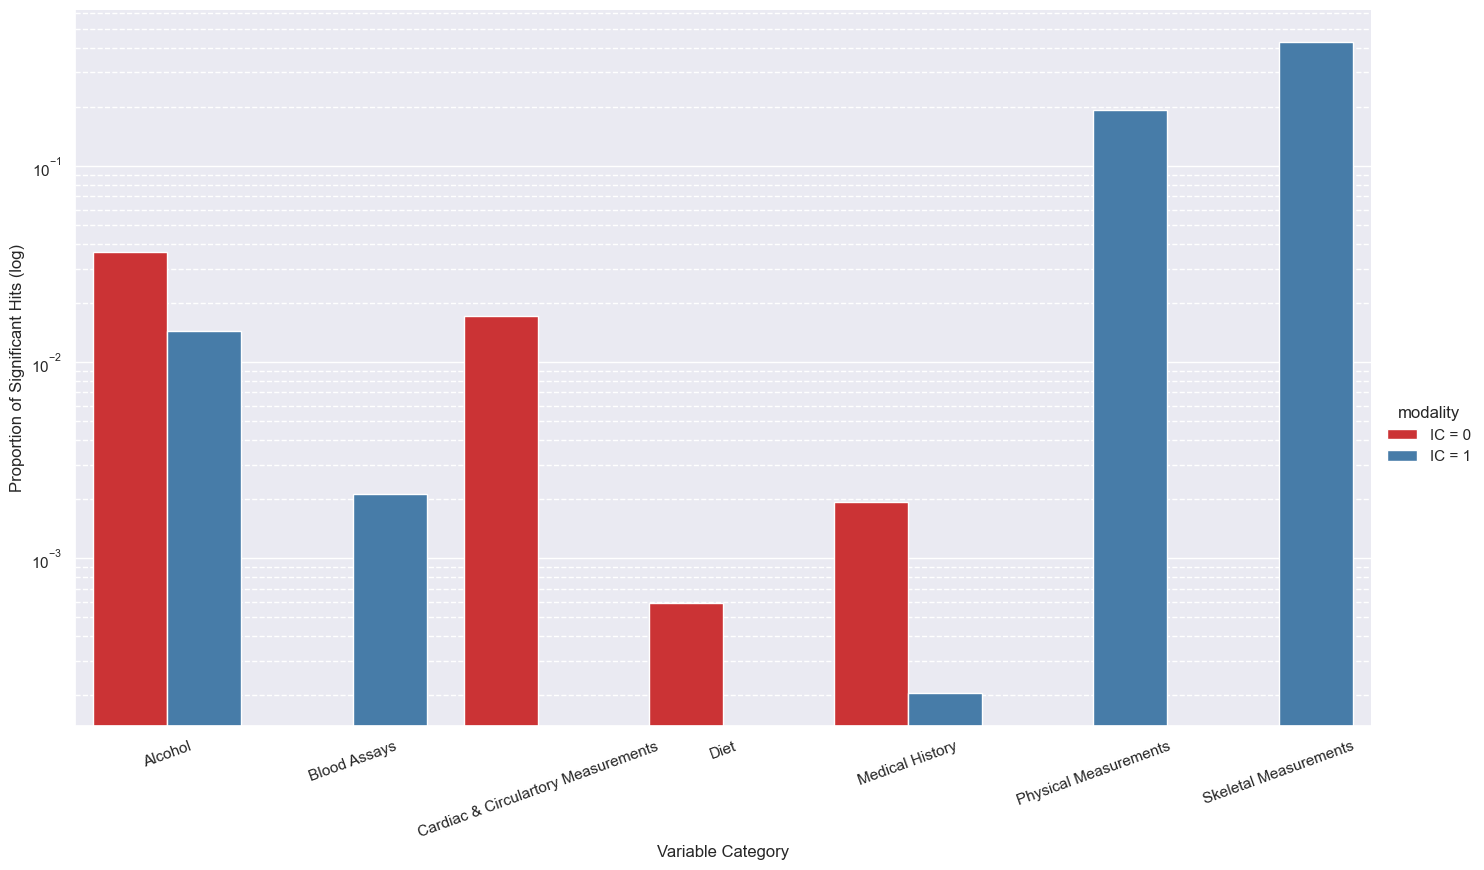

In [28]:
unique_vars_categories = list(set(vars_categories))
unique_vars_counters = []
for unique_category in unique_vars_categories:
    counter = 0
    for category in vars_categories:
        if unique_category == category:
            counter += 1
    unique_vars_counters.append(counter)
categories_of_interest = list(set(df_vars_over_bThr.Categories.to_list()))
categories_of_interest.sort()

counters_of_interest = []
for cat in categories_of_interest:
    idx = unique_vars_categories.index(cat)
    counters_of_interest.append(unique_vars_counters[idx])

modalities = []
counters = []


for idx in range(len(vars_df.modality)):
    
    modality = vars_df.iloc[idx].modality

    df_of_interest = vars_df.iloc[idx].dataframe
    bThr = vars_df.iloc[idx].bonf

    counter = []

    for category in categories_of_interest:
        counter.append(len(df_of_interest[(df_of_interest.Categories==category) & (df_of_interest.log_p_values>=bThr)]))
    
    modalities.append(modality)
    counters.append(counter)
    
unique_vars_categories2, unique_vars_counters2 = zip(*sorted(zip(unique_vars_categories, unique_vars_counters)))

counters = np.array(counters)
dct = {}
dct['modality'] = modalities
for idx, cat in enumerate(categories_of_interest):
    dct[cat] = counters[:, idx] / counters_of_interest[idx]
    
df_dct = pd.DataFrame.from_dict(dct)
df_dct.replace([np.inf, -np.inf], np.nan, inplace=True)

df_dct = pd.melt(df_dct, id_vars="modality", var_name="var_name", value_name="var_hits")

plt.figure(figsize=(16, 9.6))
sns.factorplot(x='var_name', y='var_hits', hue='modality', data=df_dct, kind='bar', height=8, 
               aspect=1.75, log=True, palette='Set1')
plt.xlabel('Variable Category')
plt.ylabel('Proportion of Significant Hits (log)')
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=20)



In [29]:
vars_df

,modality,bonf,fdr,dataframe
0,IC = 0,5.509794,3.524662,idx ...
1,IC = 1,5.509794,3.201534,idx ...


In [30]:
current_mods = vars_df.modality.values
modality_names = [
    'Subject-Direction ICA Component 1',
    'Subject-Direction ICA Component 2'
]
for idx, mod in enumerate(current_mods):
    df_dct.loc[df_dct["modality"] == mod, "modality"] = modality_names[idx]

/Users/aroibu_admin/agemapper/env/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 1600x960 with 0 Axes>

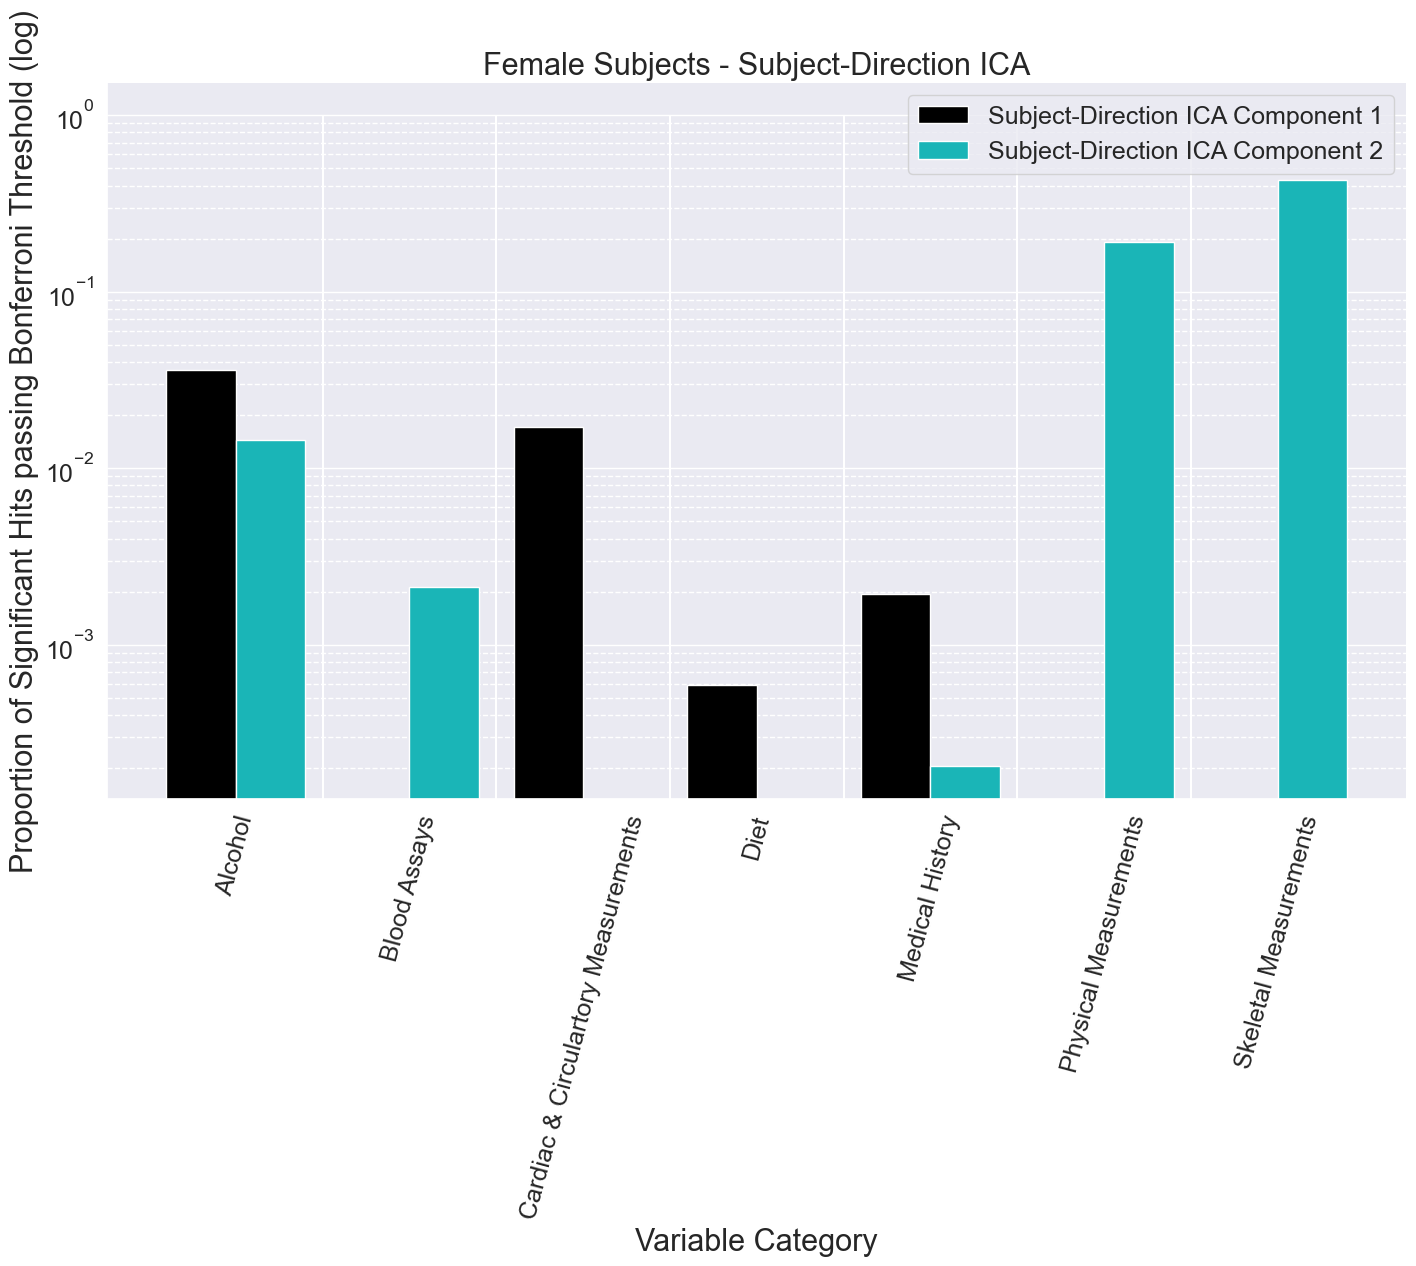

In [31]:
title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

fig = plt.figure(figsize=figsize, facecolor='white')
# fig.patch.set_facecolor('xkcd:white')
colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6',
            '#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c',
            '#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4',
            '#a6cee3', '#023fa5', '#e07b91', '#50301e']

sns.factorplot(x='var_name', y='var_hits', hue='modality', 
               data=df_dct,
               kind='bar', height=8, aspect=1.75, log=True, legend_out=False,
              palette=colorCycle)


plt.xlabel('Variable Category', fontsize=title_font_size)
plt.ylabel('Proportion of Significant Hits passing Bonferroni Threshold (log)', fontsize=title_font_size)
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=75, fontsize= ticks_font_size)
plt.yticks(fontsize= ticks_font_size)
plt.title('Female Subjects - Subject-Direction ICA', fontsize=title_font_size)
plt.vlines(x=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ymin=0, ymax=1, color='white')
# plt.ylim([0, 0.05])
plt.legend(fontsize=legend_font)# bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Female_proportion_significant_hits_subject_direction_ICA'+'.png', bbox_inches='tight', facecolor='white')

In [32]:
vars_over_FDR_list = []

for idx in range(len(vars_df)):
    df = vars_df.iloc[idx].dataframe
    FDR = vars_df.iloc[idx].fdr
    vars_over_FDR = df[df.log_p_values>=FDR].sort_values('log_p_values', ascending=False).names.to_list()
    for var in vars_over_FDR:
        vars_over_FDR_list.append(var)
        
print("Number of unique vars across all modalities: ", len(set(vars_over_FDR_list)))

unique_vars_over_FDR = list(set(vars_over_FDR_list))

unique_vars_over_FDR_categories = []

for var in unique_vars_over_FDR:
    idx = list(varsHeader).index(var)
    category = vars_categories[idx]
    unique_vars_over_FDR_categories.append(category)
    
modalities = []
pearson_rs_list = []
for var in unique_vars_over_FDR:
    modalities_with_var = []
    pearsonRs_with_var = []
    for idx in range(len(vars_df)):
        df = vars_df.iloc[idx].dataframe
        modality = vars_df.iloc[idx].modality
        FDR = vars_df.iloc[idx].bonf
        df = df[df.log_p_values>=FDR].sort_values('log_p_values', ascending=False)
        vars_over_FDR = df.names.to_list()
        pearson_r_over_FDR = df.pearson_r.to_list()
        if var in vars_over_FDR:
            modalities_with_var.append(modality)
            pearsonRs_with_var.append(pearson_r_over_FDR[vars_over_FDR.index(var)])
    modalities.append(modalities_with_var)
    pearson_rs_list.append(pearsonRs_with_var)
    
print(len(modalities))

df_vars_over_FDR = pd.DataFrame.from_dict({
    'names': unique_vars_over_FDR,
    'Categories': unique_vars_over_FDR_categories,
    'modalities': modalities,
    'pearson_r': pearson_rs_list
})



unique_vars_categories = list(set(vars_categories))
unique_vars_counters = []
for unique_category in unique_vars_categories:
    counter = 0
    for category in vars_categories:
        if unique_category == category:
            counter += 1
    unique_vars_counters.append(counter)
categories_of_interest = list(set(df_vars_over_FDR.Categories.to_list()))
categories_of_interest.sort()

counters_of_interest = []
for cat in categories_of_interest:
    idx = unique_vars_categories.index(cat)
    counters_of_interest.append(unique_vars_counters[idx])

modalities = []
counters = []


for idx in range(len(vars_df.modality)):
    
    modality = vars_df.iloc[idx].modality

    df_of_interest = vars_df.iloc[idx].dataframe
    FDR = vars_df.iloc[idx].fdr

    counter = []

    for category in categories_of_interest:
        counter.append(len(df_of_interest[(df_of_interest.Categories==category) & (df_of_interest.log_p_values>=FDR)]))
    
    modalities.append(modality)
    counters.append(counter)
    
unique_vars_categories2, unique_vars_counters2 = zip(*sorted(zip(unique_vars_categories, unique_vars_counters)))

counters = np.array(counters)
dct = {}
dct['modality'] = modalities
for idx, cat in enumerate(categories_of_interest):
    dct[cat] = counters[:, idx] / counters_of_interest[idx]
    
df_dct = pd.DataFrame.from_dict(dct)
df_dct.replace([np.inf, -np.inf], np.nan, inplace=True)

df_dct = pd.melt(df_dct, id_vars="modality", var_name="var_name", value_name="var_hits")



Number of unique vars across all modalities:  295
295


In [33]:
current_mods = vars_df.modality.values
modality_names = [
    'Subject-Direction ICA Component 1',
    'Subject-Direction ICA Component 2'
]
for idx, mod in enumerate(current_mods):
    df_dct.loc[df_dct["modality"] == mod, "modality"] = modality_names[idx]

/Users/aroibu_admin/agemapper/env/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 1600x960 with 0 Axes>

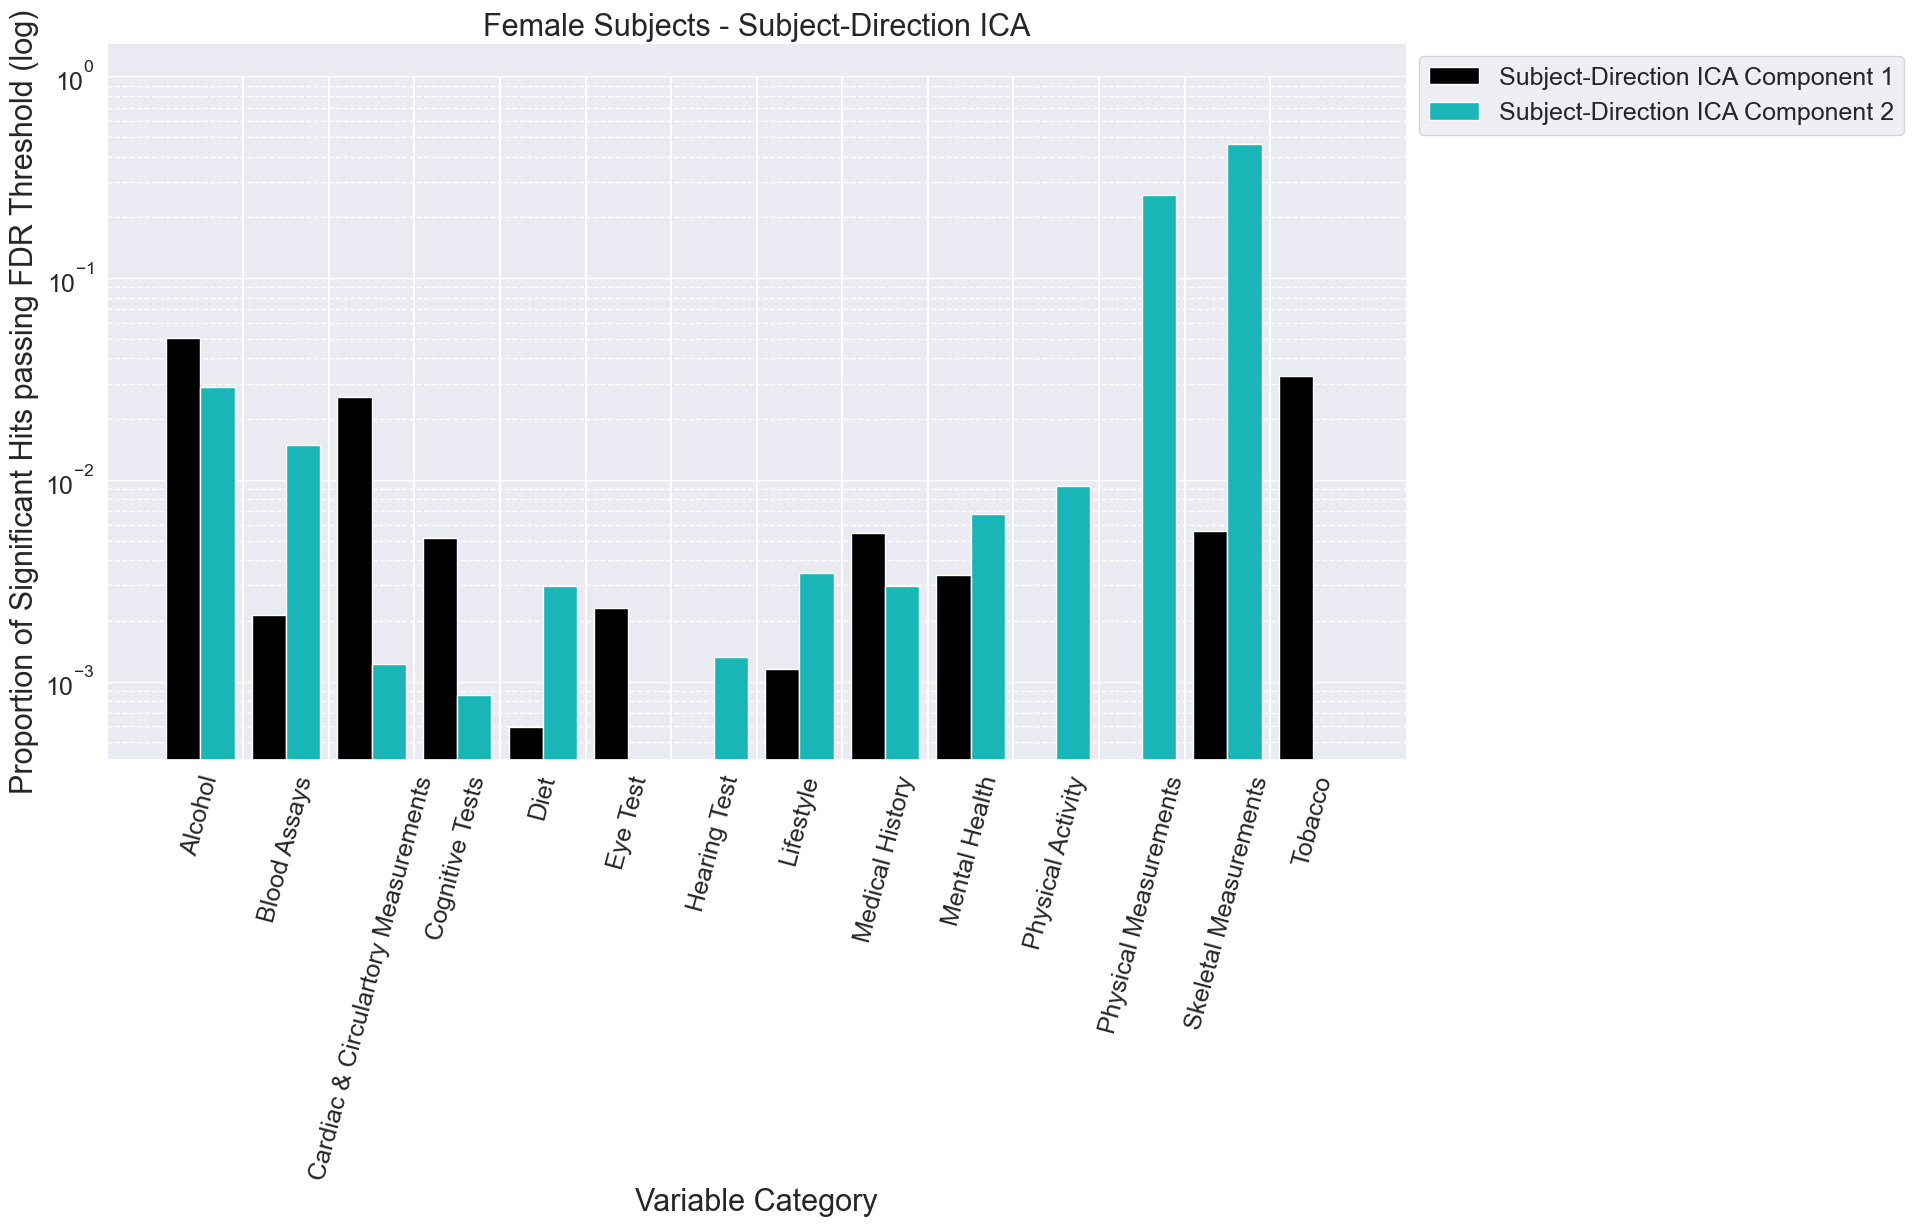

In [34]:
title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

fig = plt.figure(figsize=figsize, facecolor='white')
# fig.patch.set_facecolor('xkcd:white')
colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6',
            '#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c',
            '#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4',
            '#a6cee3', '#023fa5', '#e07b91', '#50301e']

sns.factorplot(x='var_name', y='var_hits', hue='modality', 
               data=df_dct,
               kind='bar', height=8, aspect=1.75, log=True, legend_out=False,
              palette=colorCycle)


plt.xlabel('Variable Category', fontsize=title_font_size)
plt.ylabel('Proportion of Significant Hits passing FDR Threshold (log)', fontsize=title_font_size)
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=75, fontsize= ticks_font_size)
plt.yticks(fontsize= ticks_font_size)
plt.title('Female Subjects - Subject-Direction ICA', fontsize=title_font_size)
plt.vlines(x=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5], ymin=0, ymax=1, color='white')
# plt.ylim([0, 0.05])
plt.legend(fontsize=legend_font, bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Female_FDR_proportion_significant_hits_subject_direction_ICA'+'.png', bbox_inches='tight', facecolor='white')